<a href="https://colab.research.google.com/github/dipayandas97/Indoor-Navigation-System/blob/master/(3)_2layered_SNN_GA(weights).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import drive
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split

drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/')

from neuron_models import LIF
from GA import GA
from SNN_Model import SNN_Model

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Data preparation

In [0]:
class rate_encode:
    def __init__(self, time_window, input_range, output_range):
        self.time_window = time_window
        self.min_input = input_range[0]
        self.max_input = input_range[1]
        self.min_output = output_range[0]
        self.max_output = output_range[1]

    def encode(self, vector): #1D vector
        spike_train = []
        for v in vector:
            freq = (((v-self.min_input)/(self.max_input-self.min_input)) * (self.max_output-self.min_output)) + self.min_output 
            t = (1 / freq) * 1000 #ms                    
            
            spikes = np.zeros(self.time_window)
            k=0
            while k<self.time_window and k+int(t)<self.time_window:
                k += int(t)
                spikes[k] = 1
            spike_train.append(spikes)
        spike_train = np.asarray(spike_train)
        return spike_train   

In [0]:
#functions to transform scaler data to spike time points and vice versa
#[a,b] : Min,Max value of temporal encoding
#[M:m] : Max,Min value that variable f can take

#since input range[0,22] so output range will be [0,66]. additional 33 settling time can be allotted in the beginning
#So output format: [0:33]=relaxation, true value in [33:99]

def scaler_to_temporal_value(f):
    #return (((b-a)/(M-m))*f) + (((a*M)-(b*m))/(M-m))
    return 33+(3*f) 
    
def temporal_to_scaler_value(y):
    #return (y - (((a*M)-(b*m))/(M-m))) / ((b-a)/(M-m))
    return (y-33)/3

In [0]:
#Data--------------------------------------------------------------------------------------------------------------------------------------------------
#signal #Input signal : shape(batchsize, features, timesteps)
f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/total_data.pkl', 'rb')
X, Y = pickle.load(f)
f.close()

#Rate Encode X
encoder = rate_encode(100, (-110,-22), (10, 200))
signal_X = []
for x in X:
    signal_X.append(encoder.encode(x))
signal_X = np.asarray(signal_X)

#Time Encode Y
signal_Y = []
min_y, max_y = np.min(Y), np.max(Y)
for y in Y:
    t = scaler_to_temporal_value(f=y)
    spikes_y = np.zeros((2,100))
    spikes_y[0][t[0]], spikes_y[1][t[1]] = 1,1
    signal_Y.append(spikes_y)
signal_Y = np.asarray(signal_Y)

X_train, X_test, y_train, y_test = train_test_split(signal_X, signal_Y, test_size=0.2, shuffle=True)
print('Train sizes: ',X_train.shape, y_train.shape)
print('Test sizes: ',X_test.shape, y_test.shape)



Train sizes:  (4080, 4, 100) (4080, 2, 100)
Test sizes:  (1020, 4, 100) (1020, 2, 100)


#Fitness Calculation

##error()

In [0]:
#Spike distance----------------------------------------------------------------------------------------------------------------------------------------

def error(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise Exception('Shape of y_true and y_pred is not equal')
    
    true_timestamps, pred_timestamps = np.zeros((y_true.shape[0],))-1, np.zeros((y_pred.shape[0],))-1
    
    for d in range(y_true.shape[0]):
    
        for t in range(y_true.shape[1]):
            if y_true[d][t] == 1:           # |delta(n)| = 1
                true_timestamps[d] = t
                break
        for t in range(y_pred.shape[1]):
            if y_pred[d][t] == 1:           # |V_spike| = 5
                pred_timestamps[d] = t
                break                        
        #if no spikes have been predicted
        if pred_timestamps[d] == -1:
            pred_timestamps[d] = y_true.shape[1]*2

    pred_timestamps[pred_timestamps==-1] = 0
    true_timestamps[true_timestamps==-1] = 0
    e = [(true_timestamps[i]-pred_timestamps[i])**2 for i in range(y_true.shape[0])]
    e = np.sqrt(np.sum(e))
    return e

##mp_fitness()

In [0]:
#Multi-proecssing

def mp_fitness(synapse_vector, output): #fitness of one vectored synapse
    
    #Network instance for this sub-process
    model = SNN_Model(input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)  
    initial_synapse_list = model.synapse_list
    
    synapse_id = synapse_vector[-1] 
    synapse_vector = synapse_vector[:-1]
    synapse_matrices_list = ga.vector_to_matrix(vector = synapse_vector, dummy_matrices=initial_synapse_list)

    model.set_synapses(synapse_matrices_list)

    #Error on train_data
    temp_train_score = []      
    for i in range(X_train.shape[0]):     
        model_output = model.predict(X_train[i])[-1]    #Last array represents activations of output layer
        temp_train_score.append( error(y_train[i],model_output) )

    #Error on test data
    temp_test_score = []        
    for i in range(X_test.shape[0]):   
        model_output = model.predict(X_test[i])[-1]    #Last array represents activations of output layer      
        temp_test_score.append( error(y_test[i], model_output) )

    output.put([synapse_id, np.mean(temp_train_score), np.mean(temp_test_score)])

#Main : Optimization

##Evaluating

In [0]:
f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/best_paramater_found.pkl','rb')
vector = pickle.load(f)
f.close()

In [0]:
def random_evaluate(vector, input_dim=4, neurons_per_layer=[6,2], threshold=0.2, Cm=10):

    model = SNN_Model(input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)
    dum_mat = model.synapse_list
    model.set_synapses(ga.vector_to_matrix(vector, dum_mat))

    s = np.random.randint(0,1000,1)[0]
    y_pred = model.predict(X_test[s])

    print('Evaluation Error:', error(y_test[s], y_pred[-1]))
    
    plt.figure(dpi=100, figsize=(20,4))
    for l in range(len(y_pred)):
        plt.subplot(2,len(y_pred)+1,l+1)
        plt.title('Layer '+str(l))
        for i in range(y_pred[l].shape[0]):
            plt.plot(y_pred[l][i,:])
    plt.show()

    plt.title('Y_true', fontsize=16)
    for i in range(y_test[s].shape[0]):
        plt.plot(y_test[s][i,:])
    plt.show()    

Evaluation Error: 32.38826948140329


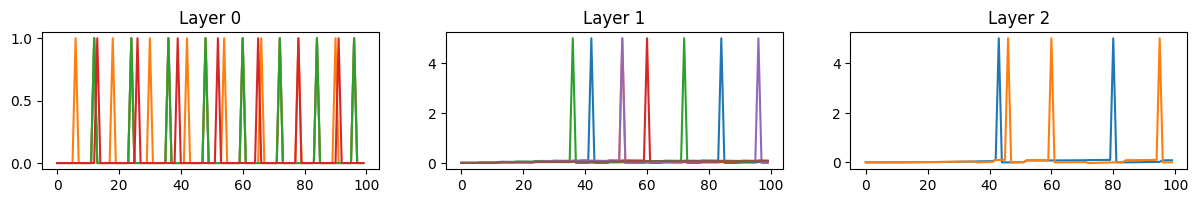

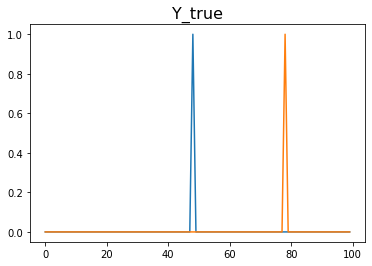

In [0]:
evaluate(vector=parents[0], threshold=0.1, Cm=10)

##Parallel GA

Generation :  1 / 50
Mean Train Error by entire population: 37.80485243139929
Mean Test Error by entire population: 37.57810658299628

Random evaluation by best parameter found so far:
Evaluation Error: 28.284271247461902


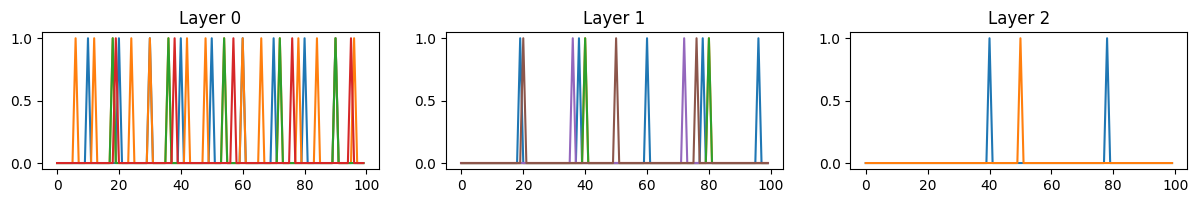

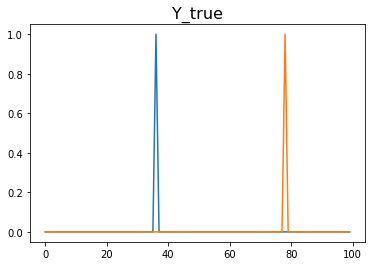

Generation :  2 / 50


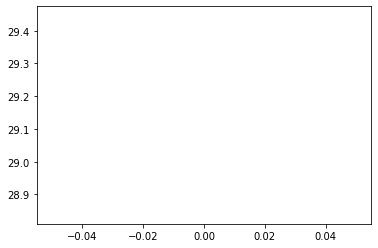

Mean Train Error by best parameters found: 29.444187347127453
Mean Test Error by best parameters found: 28.840440428809643

Mean Train Error by entire population: 47.90187508504316
Mean Test Error by entire population: 47.71197525786016

Random evaluation by best parameter found so far:
Evaluation Error: 31.32091952673165


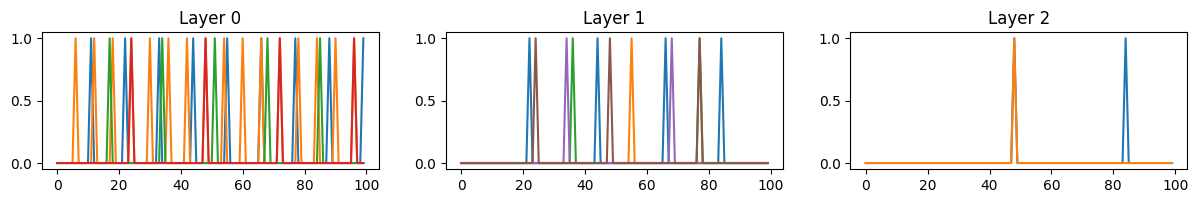

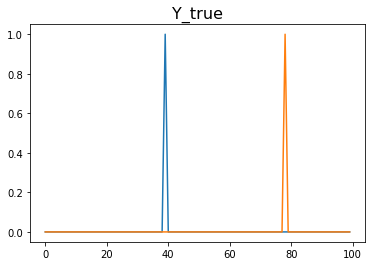

Generation :  3 / 50


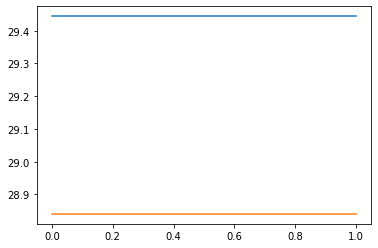

Mean Train Error by best parameters found: 29.444187347127453
Mean Test Error by best parameters found: 28.840440428809643

Mean Train Error by entire population: 50.15605330196147
Mean Test Error by entire population: 50.136952210375355

Random evaluation by best parameter found so far:
Evaluation Error: 4.47213595499958


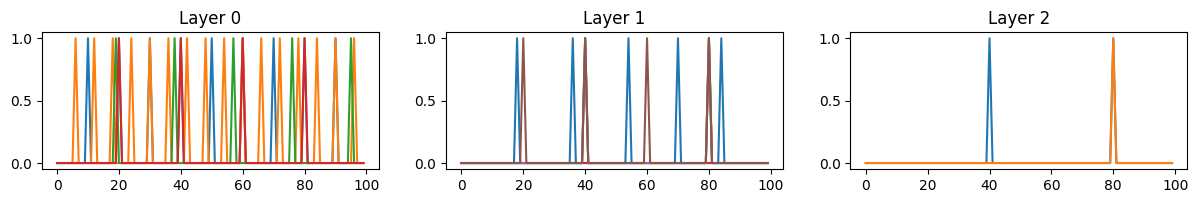

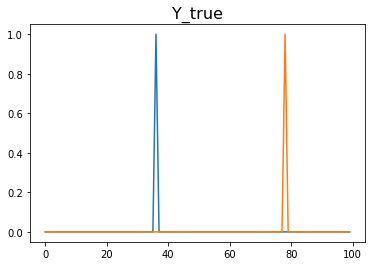

Generation :  4 / 50


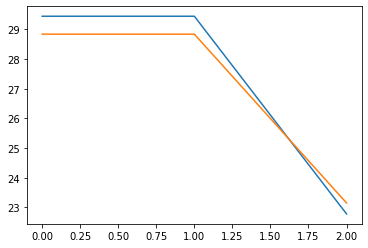

Mean Train Error by best parameters found: 22.782143946805782
Mean Test Error by best parameters found: 23.152220347354987

Mean Train Error by entire population: 58.1119076281955
Mean Test Error by entire population: 58.290339015153656

Random evaluation by best parameter found so far:
Evaluation Error: 16.278820596099706


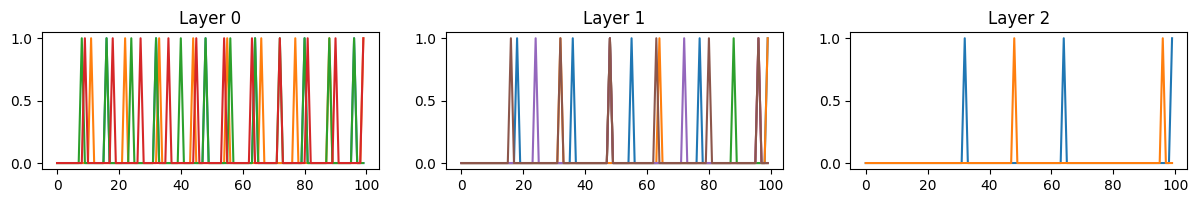

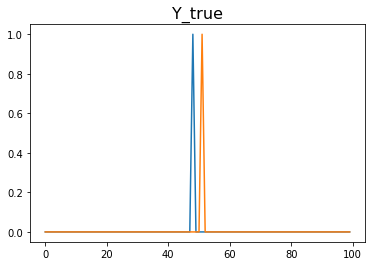

Generation :  5 / 50


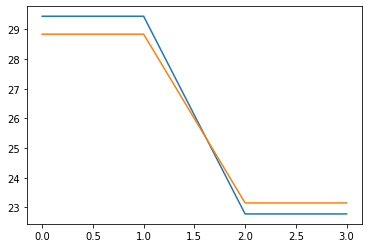

Mean Train Error by best parameters found: 22.782143946805782
Mean Test Error by best parameters found: 23.152220347354987

Mean Train Error by entire population: 61.88784008469373
Mean Test Error by entire population: 61.78954607151784

Random evaluation by best parameter found so far:
Evaluation Error: 15.620499351813308


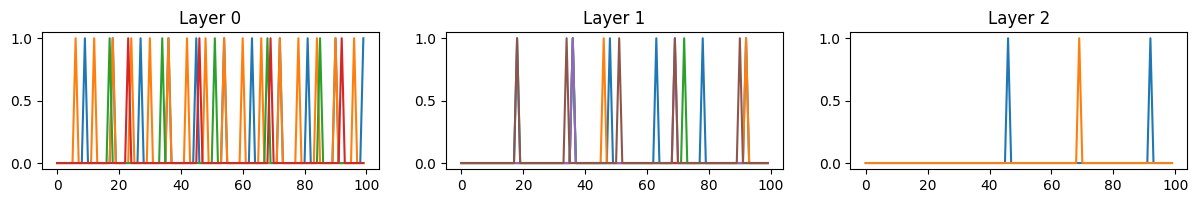

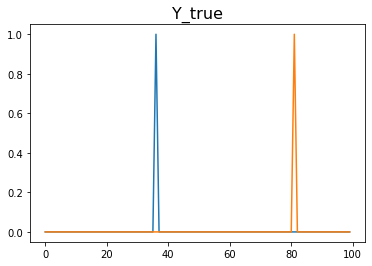

Generation :  6 / 50


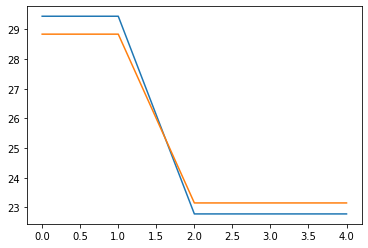

Mean Train Error by best parameters found: 22.782143946805782
Mean Test Error by best parameters found: 23.152220347354987

Mean Train Error by entire population: 58.24866632375763
Mean Test Error by entire population: 58.29071288444875

Random evaluation by best parameter found so far:
Evaluation Error: 32.89376840679705


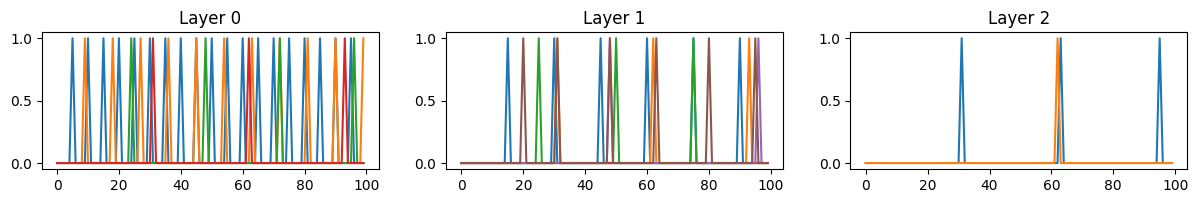

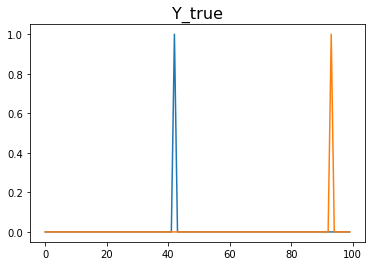

Generation :  7 / 50


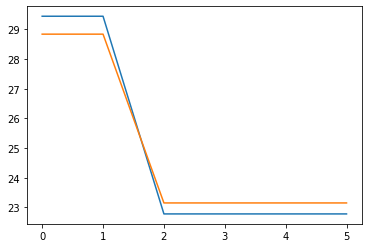

Mean Train Error by best parameters found: 22.782143946805782
Mean Test Error by best parameters found: 23.152220347354987

Mean Train Error by entire population: 69.40639983694328
Mean Test Error by entire population: 69.2617712720427

Random evaluation by best parameter found so far:
Evaluation Error: 37.589892258425


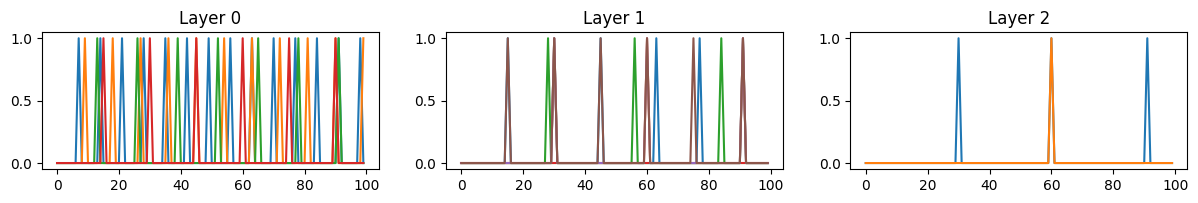

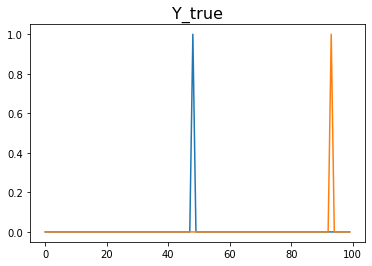

Generation :  8 / 50


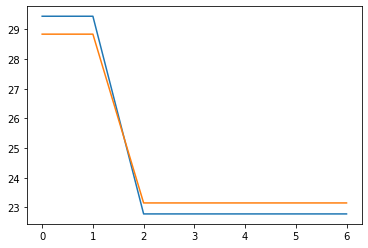

Mean Train Error by best parameters found: 22.782143946805782
Mean Test Error by best parameters found: 23.152220347354987

Mean Train Error by entire population: 52.967520233053236
Mean Test Error by entire population: 52.44562663836313

Random evaluation by best parameter found so far:
Evaluation Error: 17.0


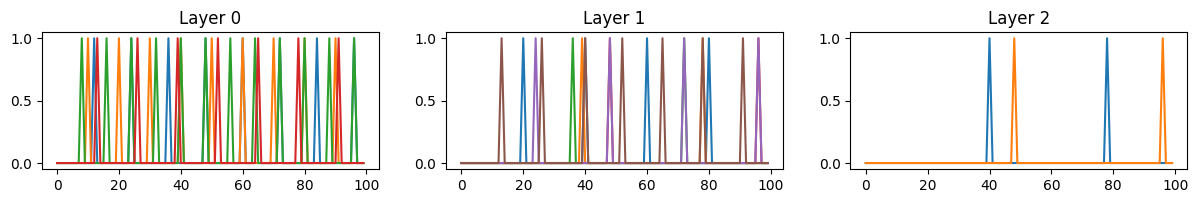

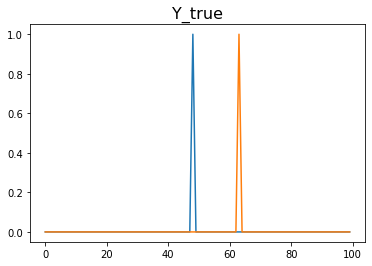

Generation :  9 / 50


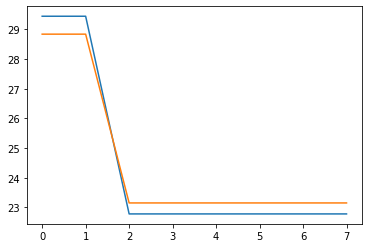

Mean Train Error by best parameters found: 22.782143946805782
Mean Test Error by best parameters found: 23.152220347354987

Mean Train Error by entire population: 45.25361614618539
Mean Test Error by entire population: 45.41617433435027

Random evaluation by best parameter found so far:
Evaluation Error: 11.704699910719626


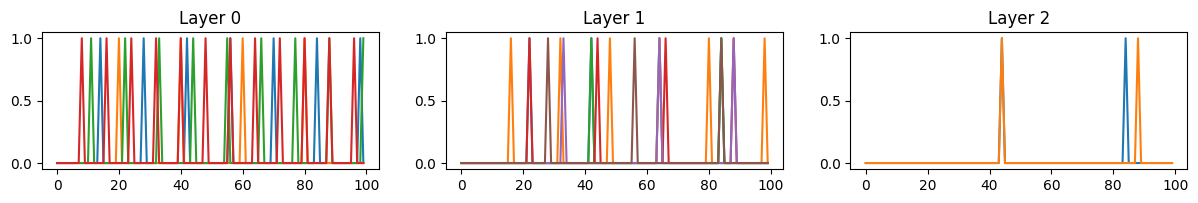

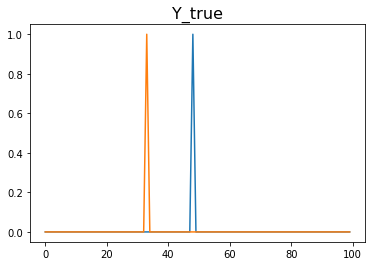

Generation :  10 / 50


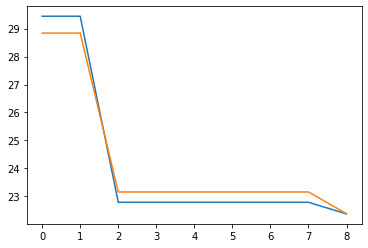

Mean Train Error by best parameters found: 22.366013567914592
Mean Test Error by best parameters found: 22.373924950750066

Mean Train Error by entire population: 40.54907354070625
Mean Test Error by entire population: 40.516814547107785

Random evaluation by best parameter found so far:
Evaluation Error: 17.08800749063506


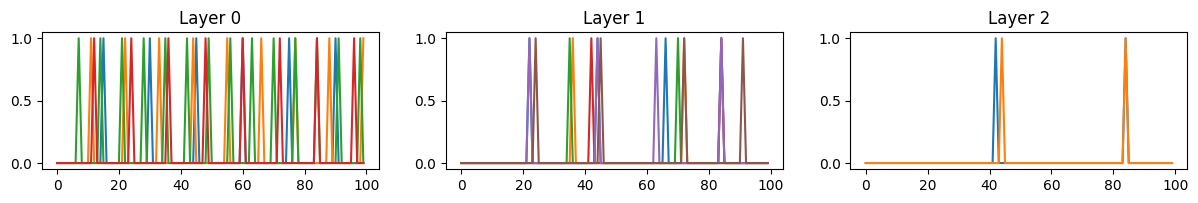

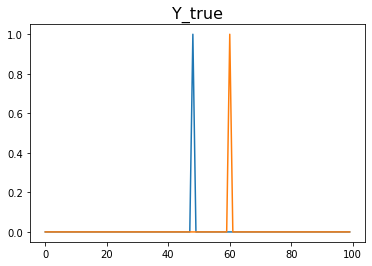

Generation :  11 / 50


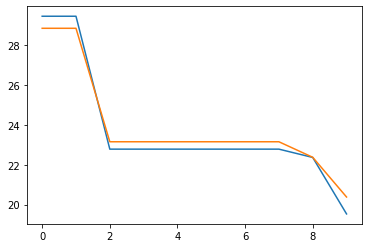

Mean Train Error by best parameters found: 19.535125953297015
Mean Test Error by best parameters found: 20.383134234749797

Mean Train Error by entire population: 54.47672299074296
Mean Test Error by entire population: 54.029687661889284

Random evaluation by best parameter found so far:
Evaluation Error: 24.186773244895647


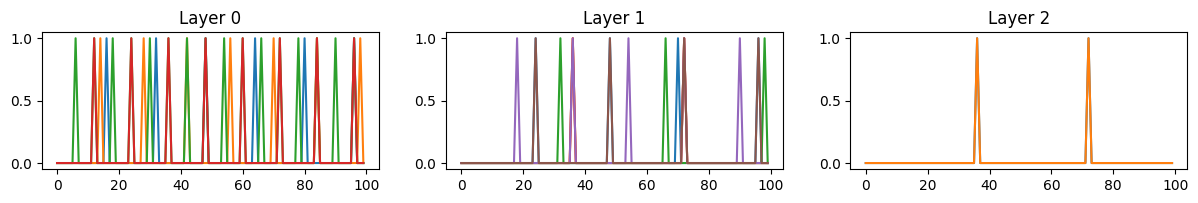

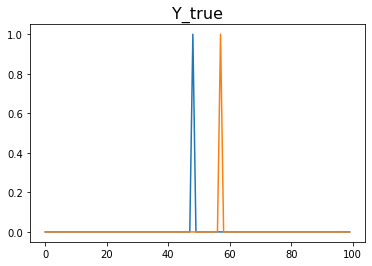

Generation :  12 / 50


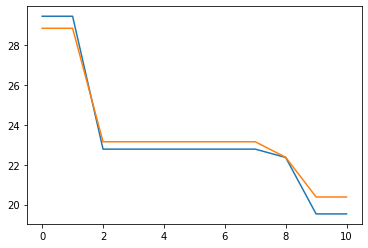

Mean Train Error by best parameters found: 19.535125953297015
Mean Test Error by best parameters found: 20.383134234749797

Mean Train Error by entire population: 38.66922685616322
Mean Test Error by entire population: 38.619473584268

Random evaluation by best parameter found so far:
Evaluation Error: 32.01562118716424


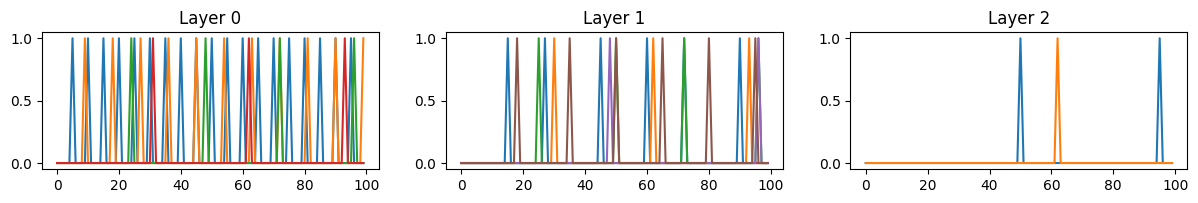

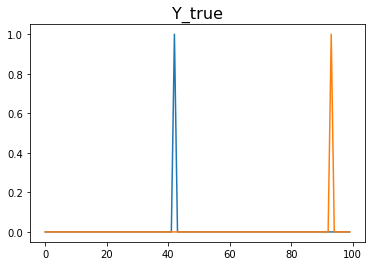

Generation :  13 / 50


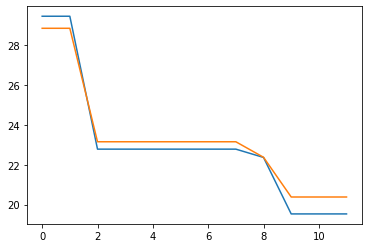

Mean Train Error by best parameters found: 19.535125953297015
Mean Test Error by best parameters found: 20.383134234749797

Mean Train Error by entire population: 50.05478560594299
Mean Test Error by entire population: 49.83999808078092

Random evaluation by best parameter found so far:
Evaluation Error: 6.708203932499369


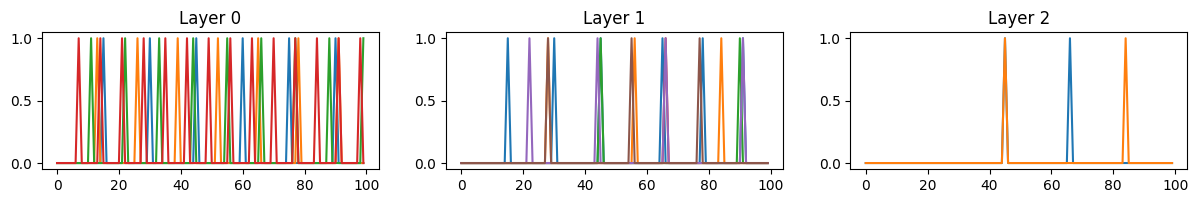

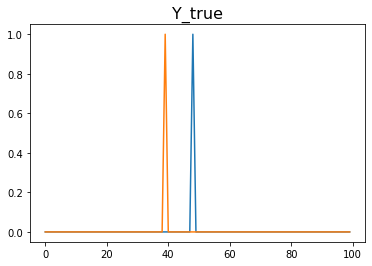

Generation :  14 / 50


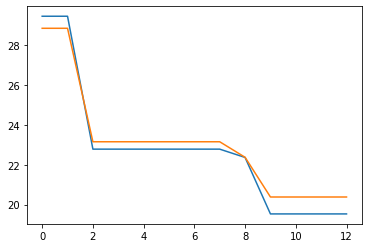

Mean Train Error by best parameters found: 19.535125953297015
Mean Test Error by best parameters found: 20.383134234749797

Mean Train Error by entire population: 50.843975901063196
Mean Test Error by entire population: 50.63552853536663

Random evaluation by best parameter found so far:
Evaluation Error: 31.906112267087632


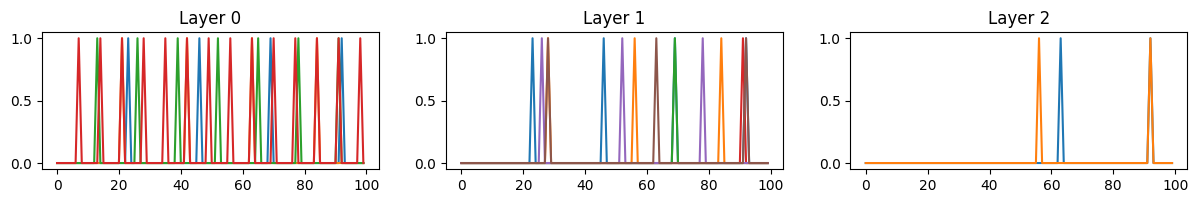

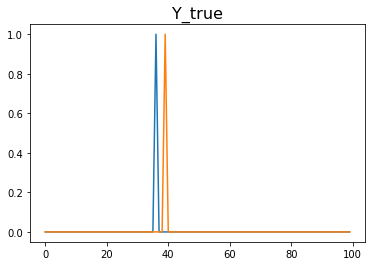

Generation :  15 / 50


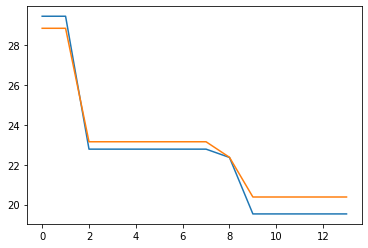

Mean Train Error by best parameters found: 19.535125953297015
Mean Test Error by best parameters found: 20.383134234749797

Mean Train Error by entire population: 45.90683294602286
Mean Test Error by entire population: 45.88337132383402

Random evaluation by best parameter found so far:
Evaluation Error: 12.727922061357855


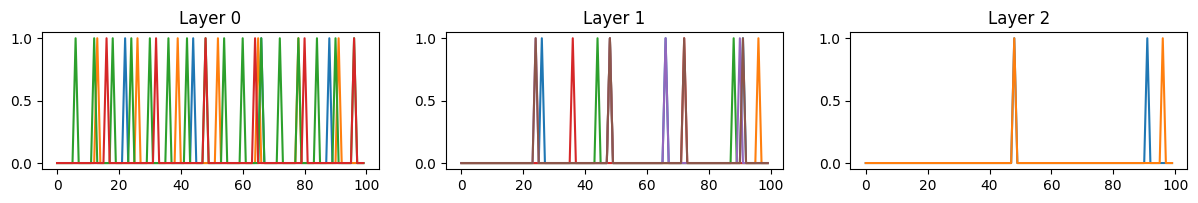

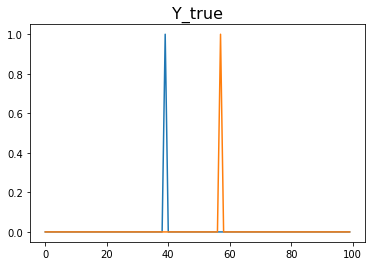

Generation :  16 / 50


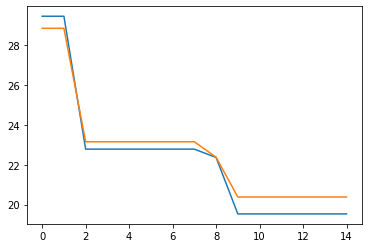

Mean Train Error by best parameters found: 19.535125953297015
Mean Test Error by best parameters found: 20.383134234749797

Mean Train Error by entire population: 49.946616912876124
Mean Test Error by entire population: 50.096027090433694

Random evaluation by best parameter found so far:
Evaluation Error: 35.17101079013795


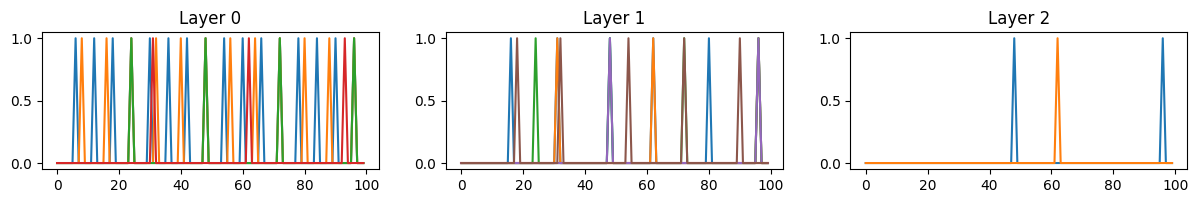

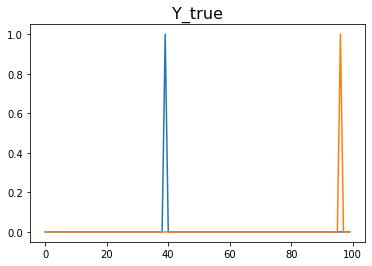

Generation :  17 / 50


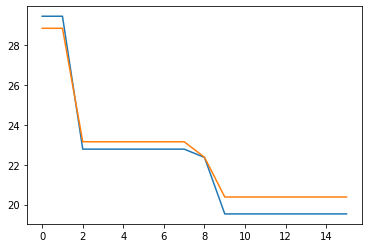

Mean Train Error by best parameters found: 19.535125953297015
Mean Test Error by best parameters found: 20.383134234749797

Mean Train Error by entire population: 52.31506886714082
Mean Test Error by entire population: 52.13042536631708

Random evaluation by best parameter found so far:
Evaluation Error: 12.727922061357855


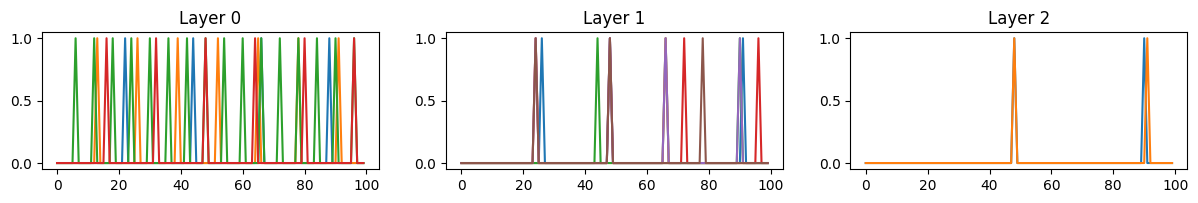

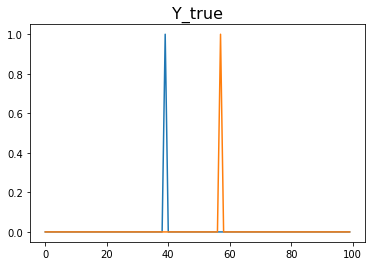

Generation :  18 / 50


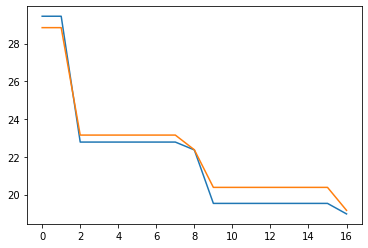

Mean Train Error by best parameters found: 18.978141202676877
Mean Test Error by best parameters found: 19.166077707213322

Mean Train Error by entire population: 31.683411451945613
Mean Test Error by entire population: 31.907064361559755

Random evaluation by best parameter found so far:
Evaluation Error: 13.892443989449804


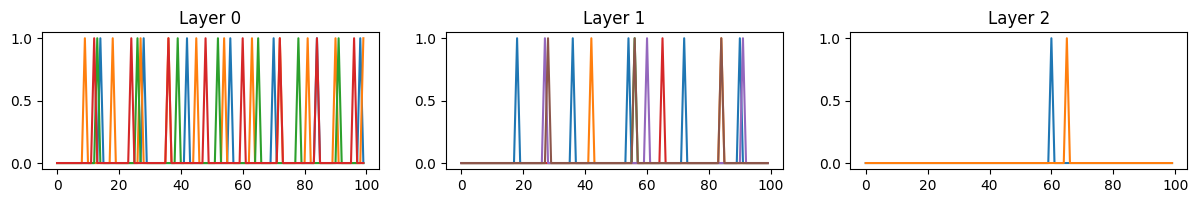

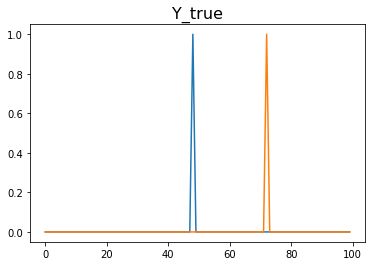

Generation :  19 / 50


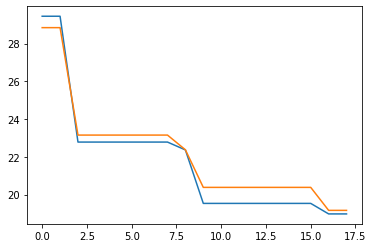

Mean Train Error by best parameters found: 18.978141202676877
Mean Test Error by best parameters found: 19.166077707213322

Mean Train Error by entire population: 49.412765049008975
Mean Test Error by entire population: 49.42405195521096

Random evaluation by best parameter found so far:
Evaluation Error: 37.16180835212409


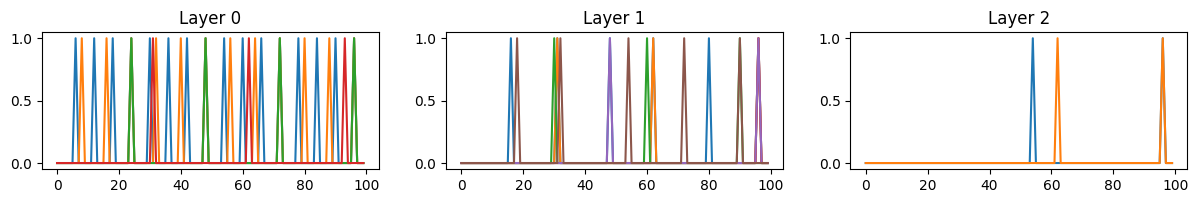

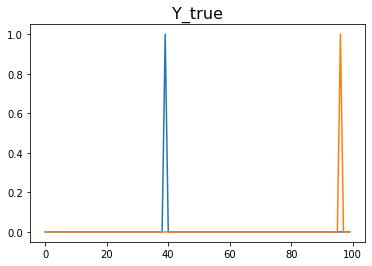

Generation :  20 / 50


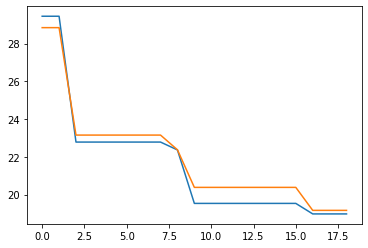

Mean Train Error by best parameters found: 18.978141202676877
Mean Test Error by best parameters found: 19.166077707213322

Mean Train Error by entire population: 43.63784141835204
Mean Test Error by entire population: 43.641529557696465

Random evaluation by best parameter found so far:
Evaluation Error: 10.816653826391969


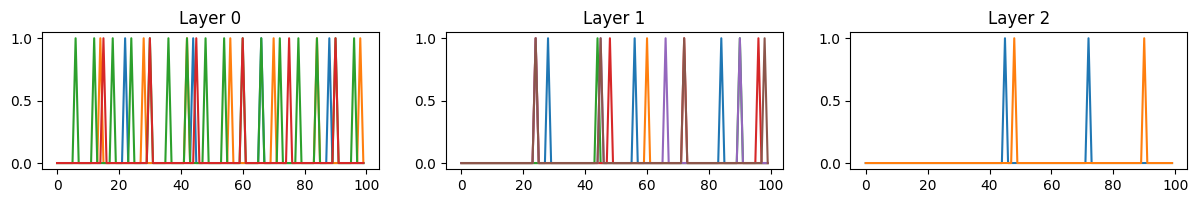

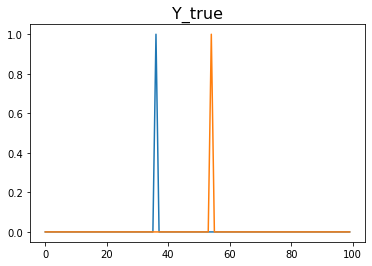

Generation :  21 / 50


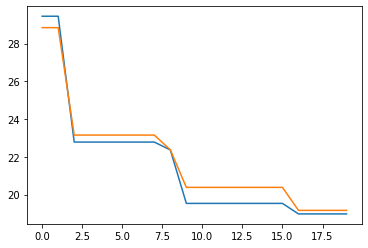

Mean Train Error by best parameters found: 18.978141202676877
Mean Test Error by best parameters found: 19.166077707213322

Mean Train Error by entire population: 35.02039577401817
Mean Test Error by entire population: 34.99925045686376

Random evaluation by best parameter found so far:
Evaluation Error: 8.246211251235321


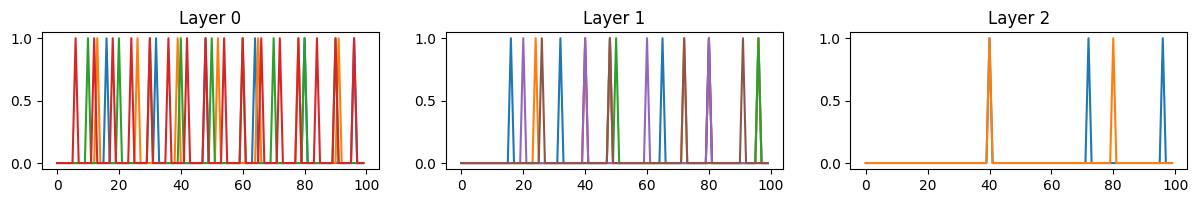

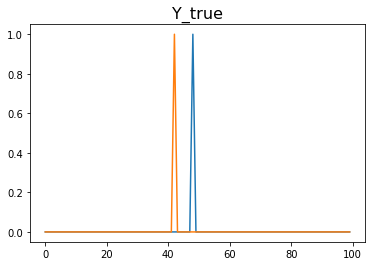

Generation :  22 / 50


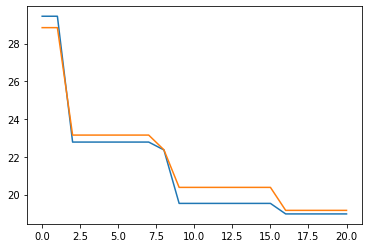

Mean Train Error by best parameters found: 18.978141202676877
Mean Test Error by best parameters found: 19.166077707213322

Mean Train Error by entire population: 58.1109514660648
Mean Test Error by entire population: 57.7939696010944

Random evaluation by best parameter found so far:
Evaluation Error: 12.727922061357855


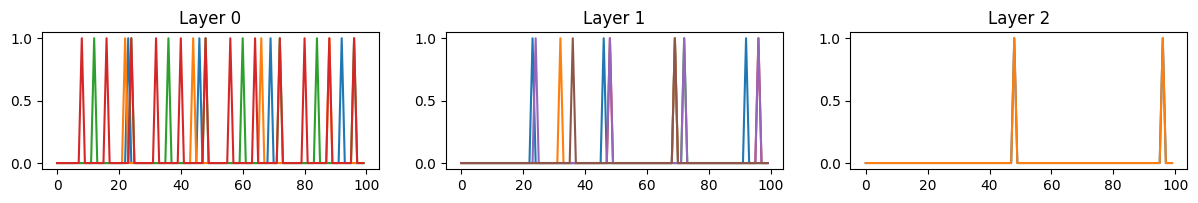

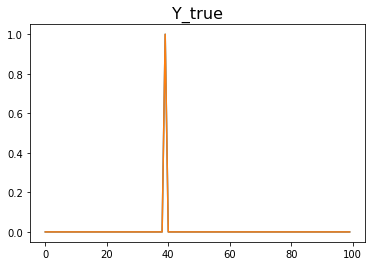

Generation :  23 / 50


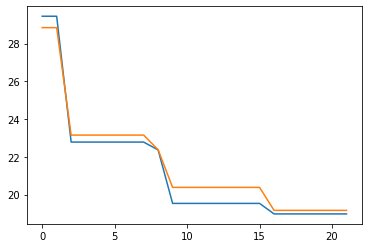

Mean Train Error by best parameters found: 18.978141202676877
Mean Test Error by best parameters found: 19.166077707213322

Mean Train Error by entire population: 48.928794616575644
Mean Test Error by entire population: 48.77093100990559

Random evaluation by best parameter found so far:
Evaluation Error: 5.0990195135927845


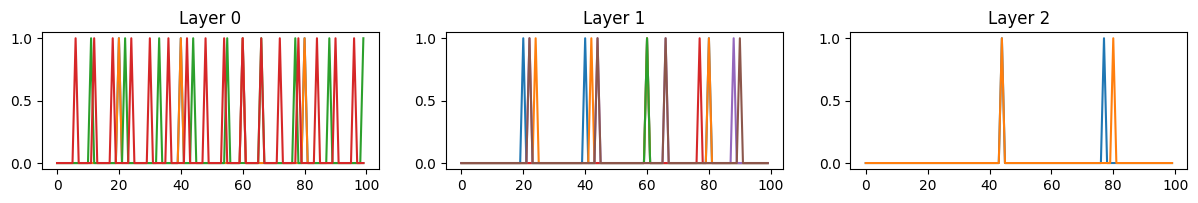

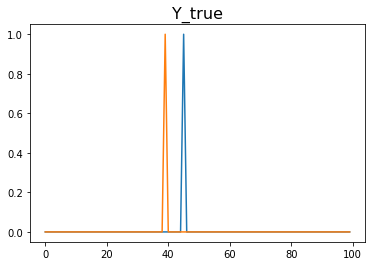

Generation :  24 / 50


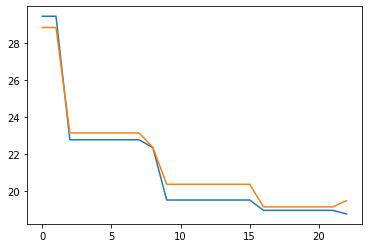

Mean Train Error by best parameters found: 18.785831787902747
Mean Test Error by best parameters found: 19.498642239244845

Mean Train Error by entire population: 47.97502718166613
Mean Test Error by entire population: 47.961509880679756

Random evaluation by best parameter found so far:
Evaluation Error: 13.45362404707371


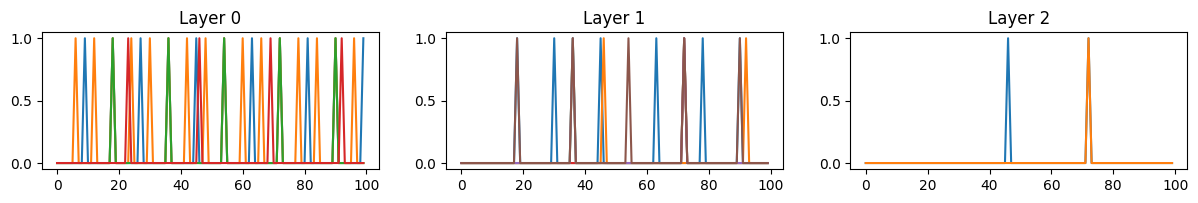

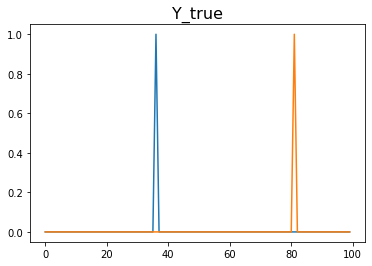

Generation :  25 / 50


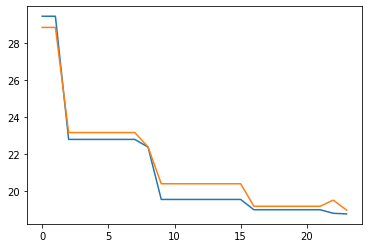

Mean Train Error by best parameters found: 18.75217606946933
Mean Test Error by best parameters found: 18.959056994229265

Mean Train Error by entire population: 47.98041245716721
Mean Test Error by entire population: 48.00706848495722

Random evaluation by best parameter found so far:
Evaluation Error: 18.973665961010276


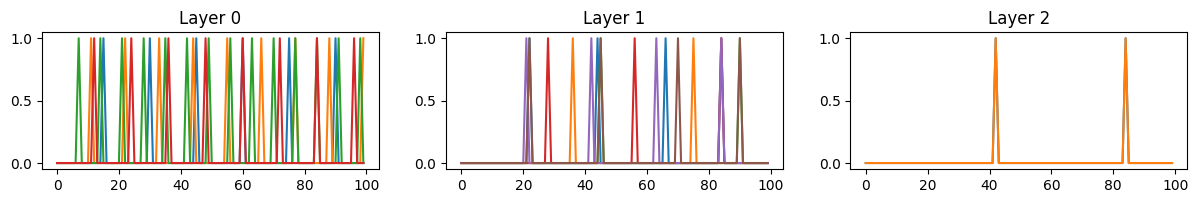

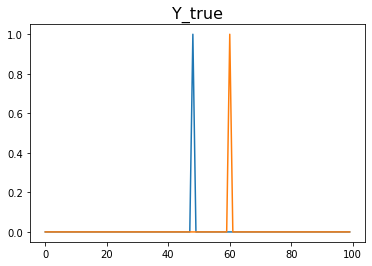

Generation :  26 / 50


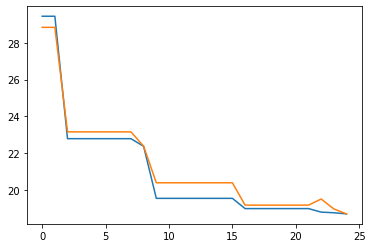

Mean Train Error by best parameters found: 18.690705013146733
Mean Test Error by best parameters found: 18.688422376045384

Mean Train Error by entire population: 35.92280546276268
Mean Test Error by entire population: 35.766196654450795

Random evaluation by best parameter found so far:
Evaluation Error: 16.97056274847714


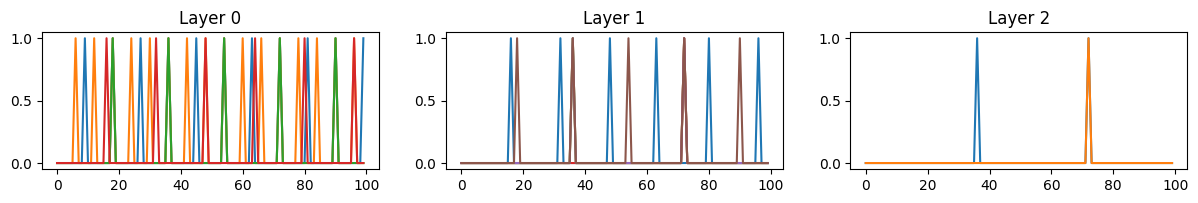

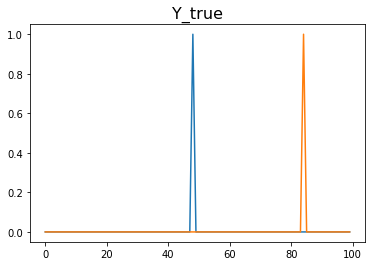

Generation :  27 / 50


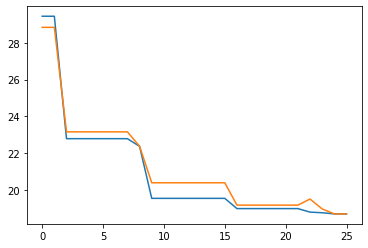

Mean Train Error by best parameters found: 18.690705013146733
Mean Test Error by best parameters found: 18.688422376045384

Mean Train Error by entire population: 51.44478031252877
Mean Test Error by entire population: 51.158089599261295

Random evaluation by best parameter found so far:
Evaluation Error: 17.46424919657298


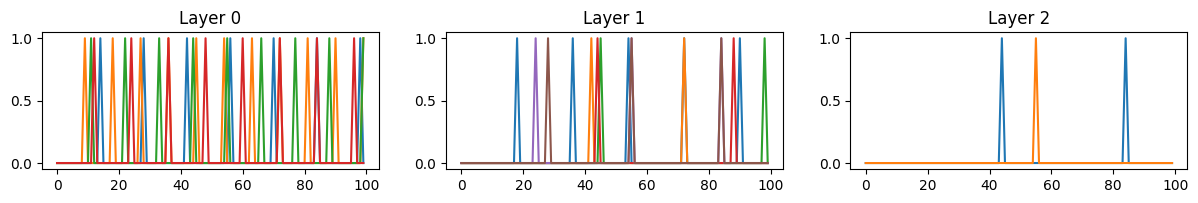

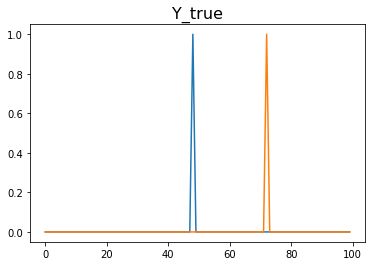

Generation :  28 / 50


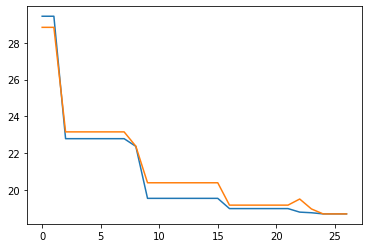

Mean Train Error by best parameters found: 18.690705013146733
Mean Test Error by best parameters found: 18.688422376045384

Mean Train Error by entire population: 54.932769936547864
Mean Test Error by entire population: 54.58667917032907

Random evaluation by best parameter found so far:
Evaluation Error: 12.727922061357855


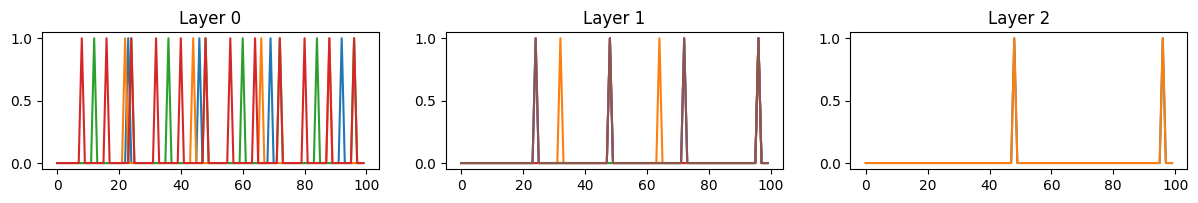

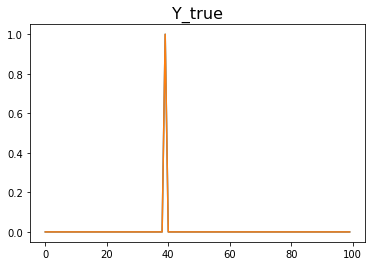

Generation :  29 / 50


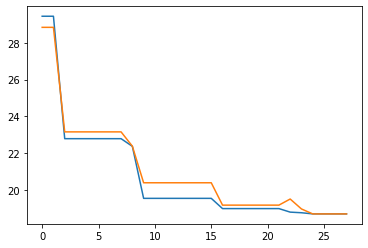

Mean Train Error by best parameters found: 18.690705013146733
Mean Test Error by best parameters found: 18.688422376045384

Mean Train Error by entire population: 60.16983787949711
Mean Test Error by entire population: 59.702484078116605

Random evaluation by best parameter found so far:
Evaluation Error: 5.0990195135927845


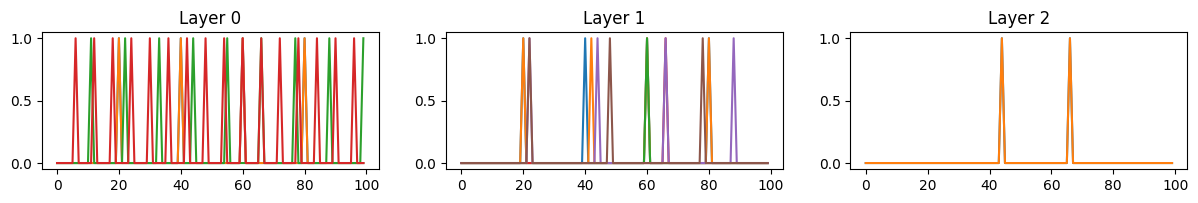

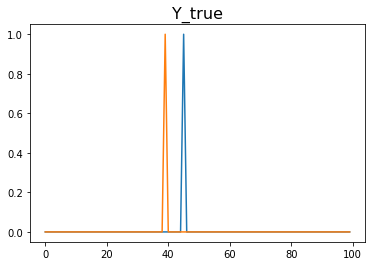

Generation :  30 / 50


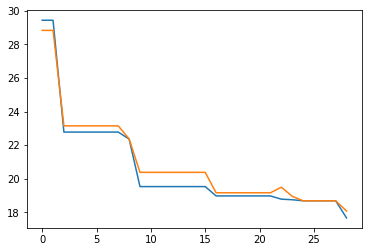

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 45.88892539651275
Mean Test Error by entire population: 45.77491061006611

Random evaluation by best parameter found so far:
Evaluation Error: 4.242640687119285


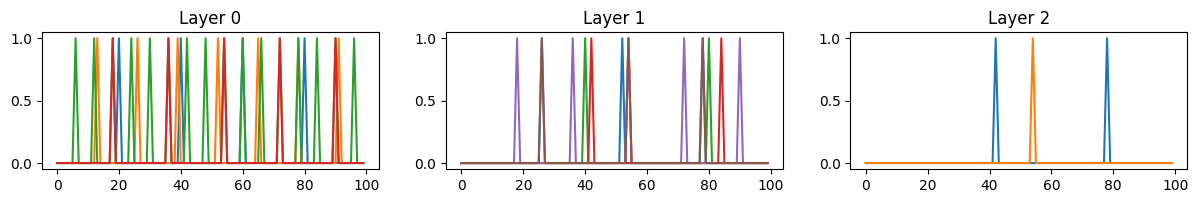

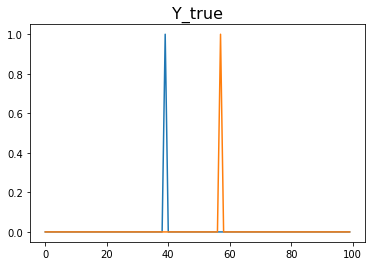

Generation :  31 / 50


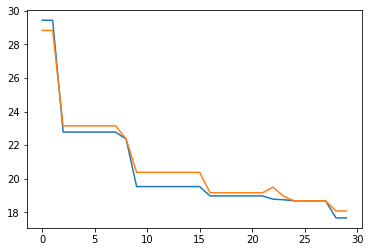

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 27.26011437752184
Mean Test Error by entire population: 27.174336640066084

Random evaluation by best parameter found so far:
Evaluation Error: 40.311288741492746


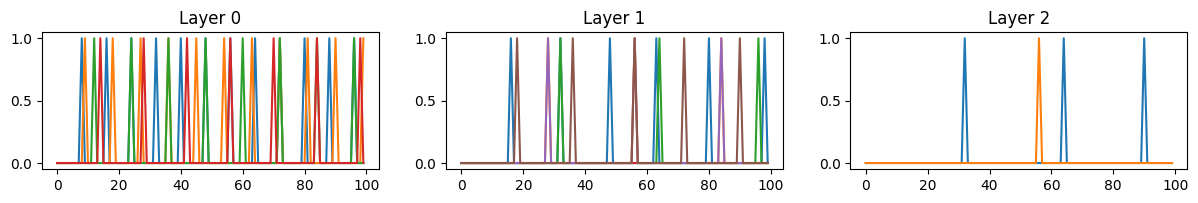

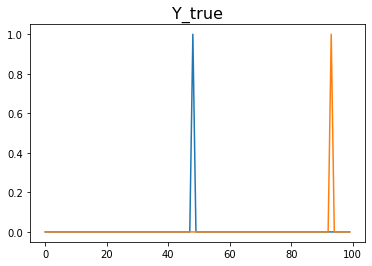

Generation :  32 / 50


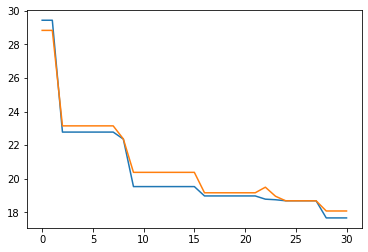

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 25.558762218940096
Mean Test Error by entire population: 25.727789875362415

Random evaluation by best parameter found so far:
Evaluation Error: 6.0


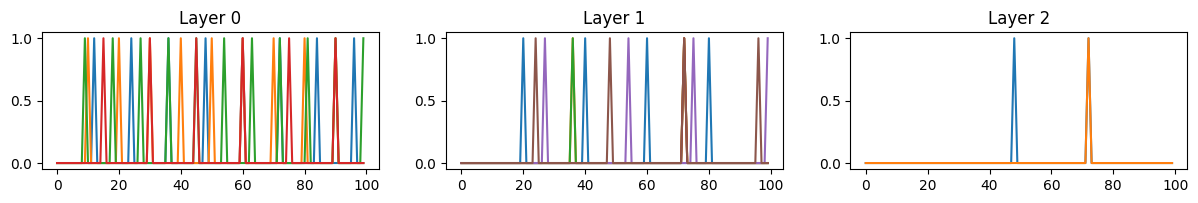

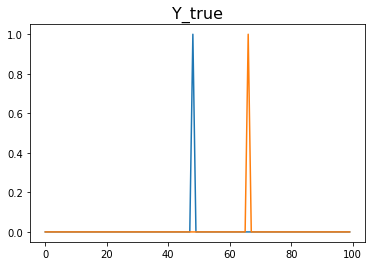

Generation :  33 / 50


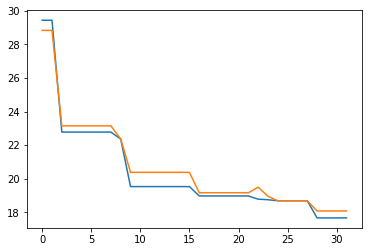

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 47.49744566366812
Mean Test Error by entire population: 47.330302125157004

Random evaluation by best parameter found so far:
Evaluation Error: 13.416407864998739


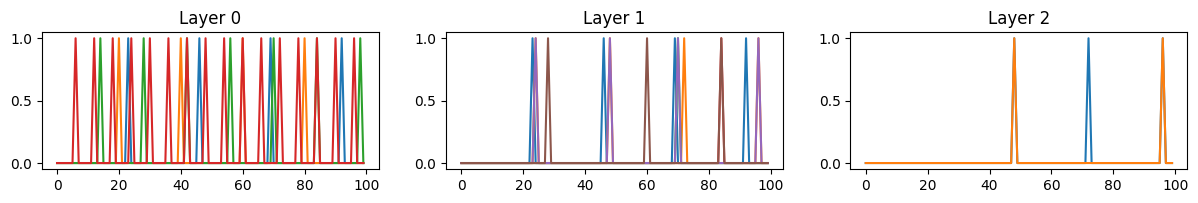

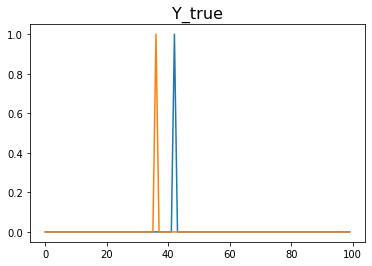

Generation :  34 / 50


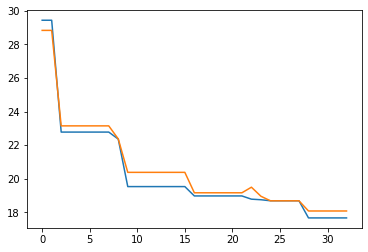

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 49.35005364769241
Mean Test Error by entire population: 49.07572339338654

Random evaluation by best parameter found so far:
Evaluation Error: 11.045361017187261


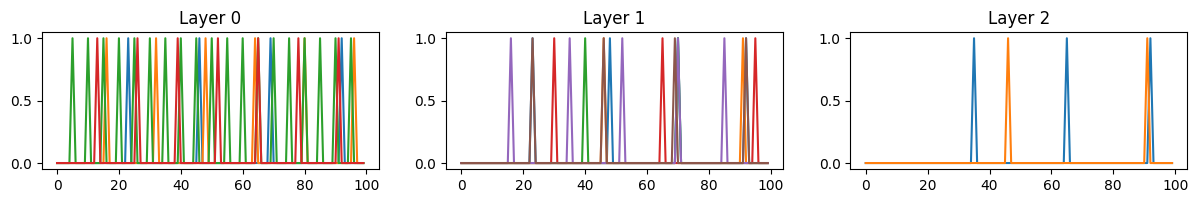

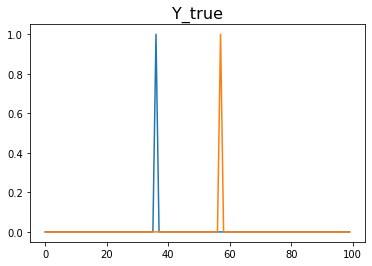

Generation :  35 / 50


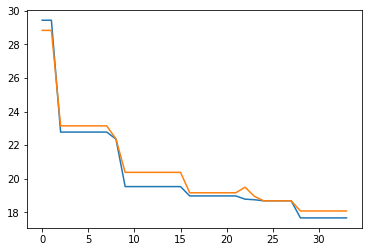

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 57.55461572844813
Mean Test Error by entire population: 56.840915134565876

Random evaluation by best parameter found so far:
Evaluation Error: 22.02271554554524


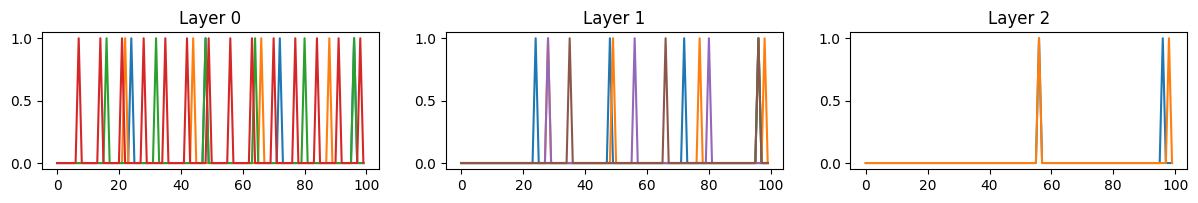

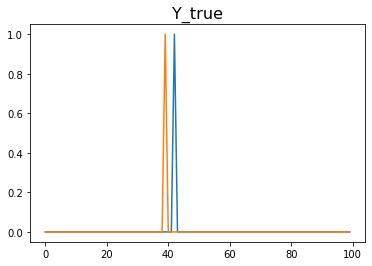

Generation :  36 / 50


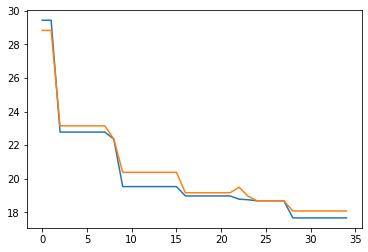

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 39.65118580240193
Mean Test Error by entire population: 39.4288628272155

Random evaluation by best parameter found so far:
Evaluation Error: 11.180339887498949


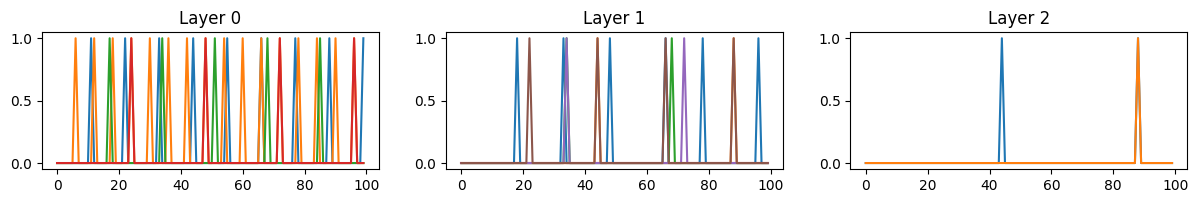

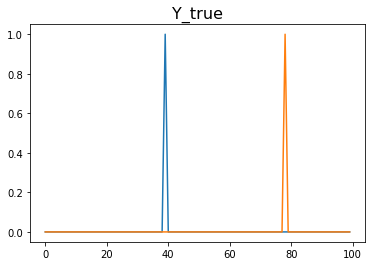

Generation :  37 / 50


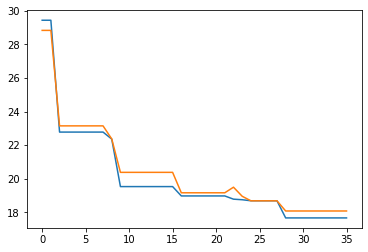

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 36.95113869300446
Mean Test Error by entire population: 36.70035974129827

Random evaluation by best parameter found so far:
Evaluation Error: 9.0


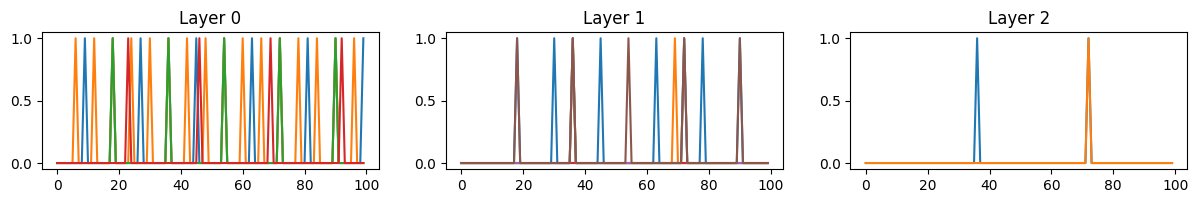

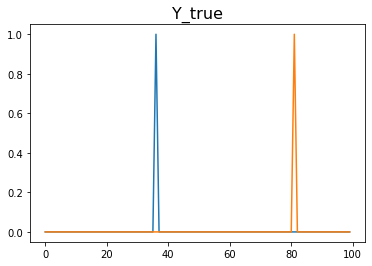

Generation :  38 / 50


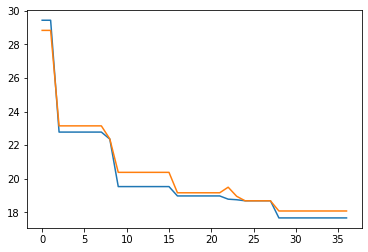

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 47.9705087906686
Mean Test Error by entire population: 47.7769195796928

Random evaluation by best parameter found so far:
Evaluation Error: 0.0


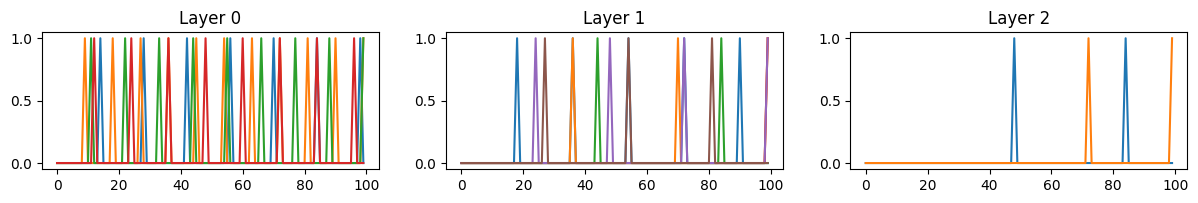

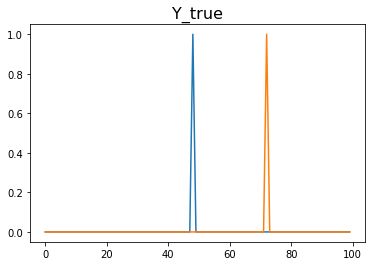

Generation :  39 / 50


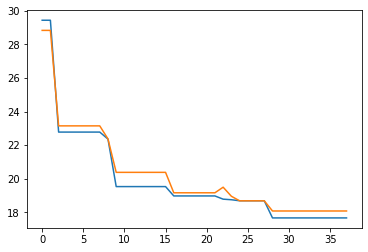

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 44.33877327574328
Mean Test Error by entire population: 44.00331743720039

Random evaluation by best parameter found so far:
Evaluation Error: 7.0


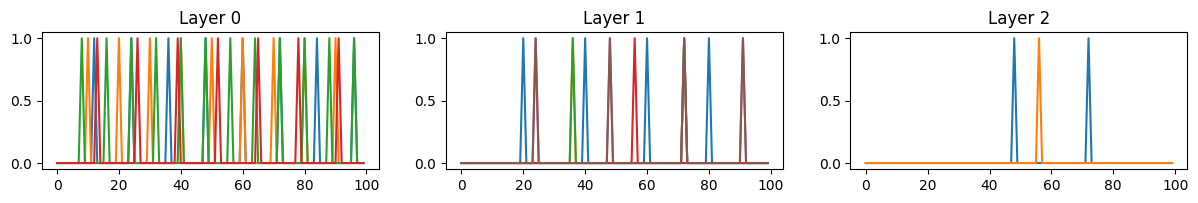

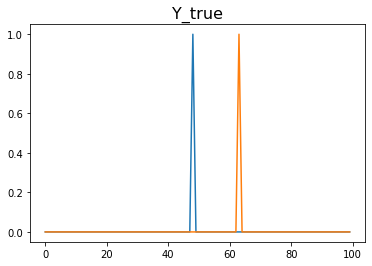

Generation :  40 / 50


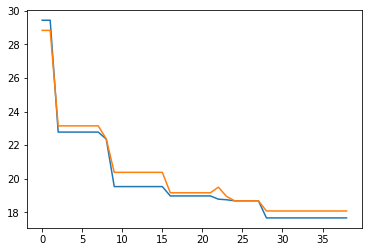

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 35.55585959502994
Mean Test Error by entire population: 35.4656091675286

Random evaluation by best parameter found so far:
Evaluation Error: 40.024992192379


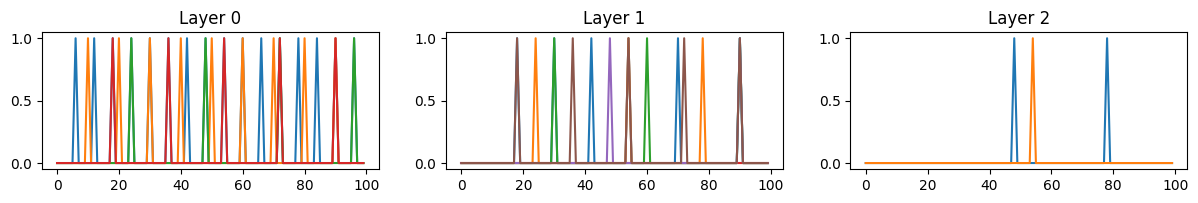

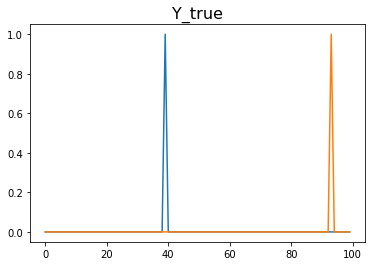

Generation :  41 / 50


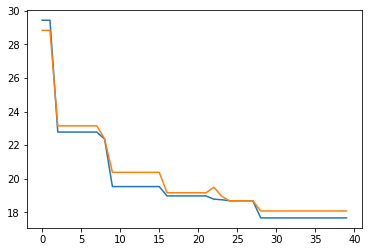

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 35.503799716409176
Mean Test Error by entire population: 35.37512174667374

Random evaluation by best parameter found so far:
Evaluation Error: 24.351591323771842


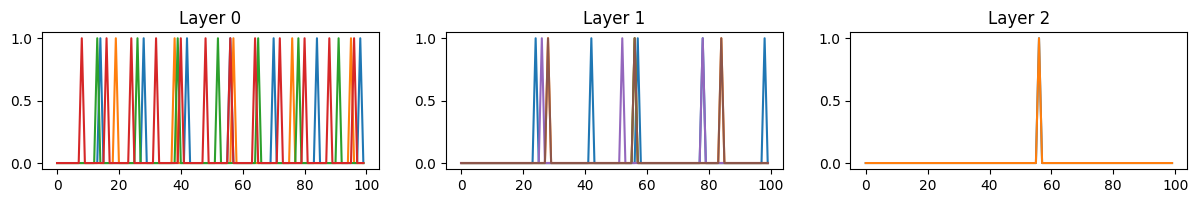

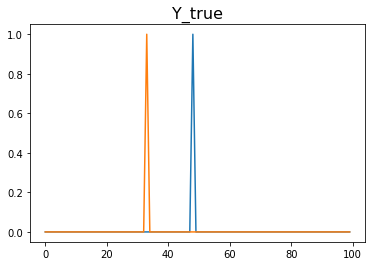

Generation :  42 / 50


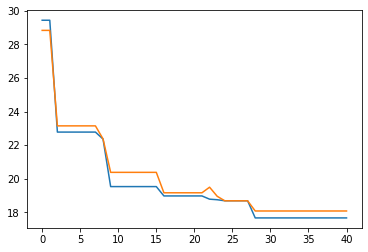

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 38.356259714757854
Mean Test Error by entire population: 38.30841387239615

Random evaluation by best parameter found so far:
Evaluation Error: 9.0


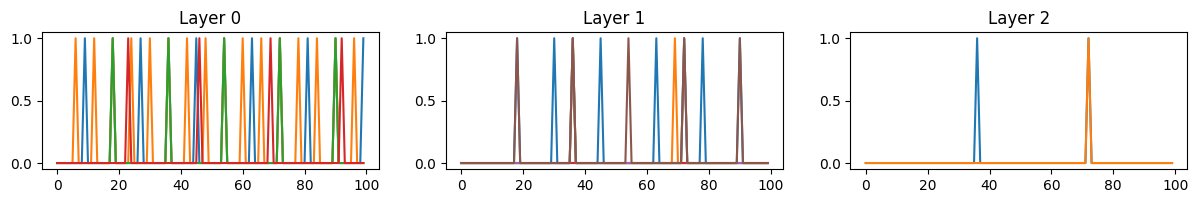

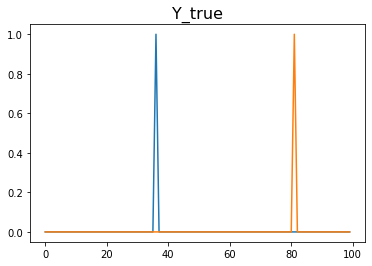

Generation :  43 / 50


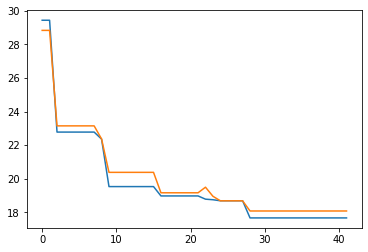

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 50.02822458923829
Mean Test Error by entire population: 49.84865399876714

Random evaluation by best parameter found so far:
Evaluation Error: 5.0990195135927845


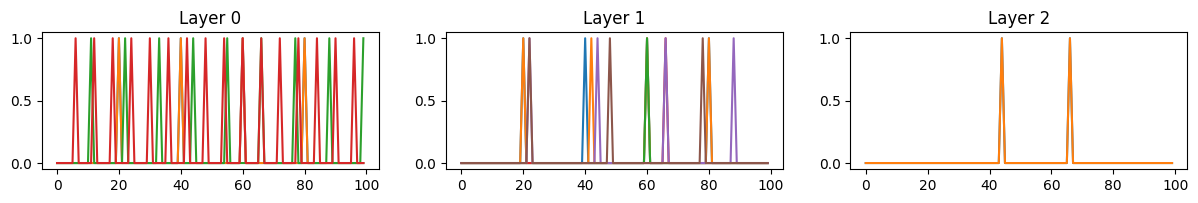

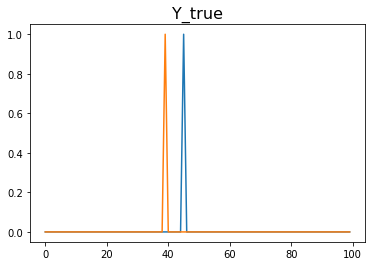

Generation :  44 / 50


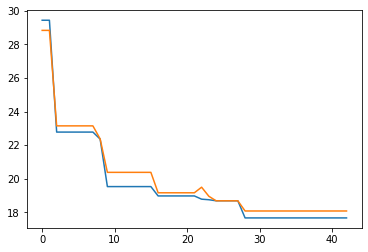

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 48.356687632332466
Mean Test Error by entire population: 48.22596596167512

Random evaluation by best parameter found so far:
Evaluation Error: 6.708203932499369


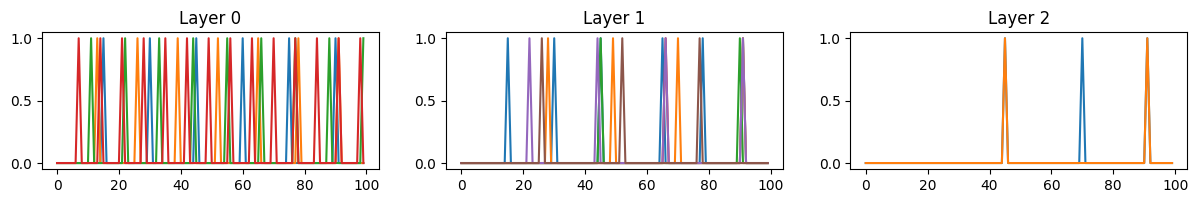

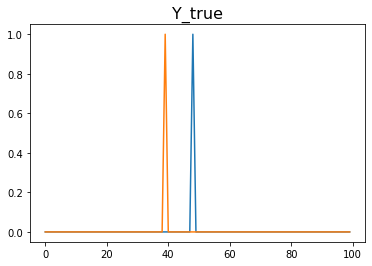

Generation :  45 / 50


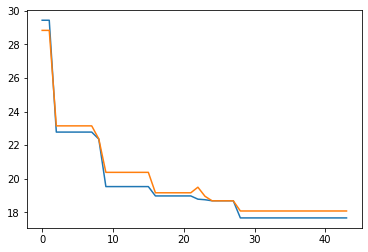

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 45.21478498178278
Mean Test Error by entire population: 45.11695295790189

Random evaluation by best parameter found so far:
Evaluation Error: 10.816653826391969


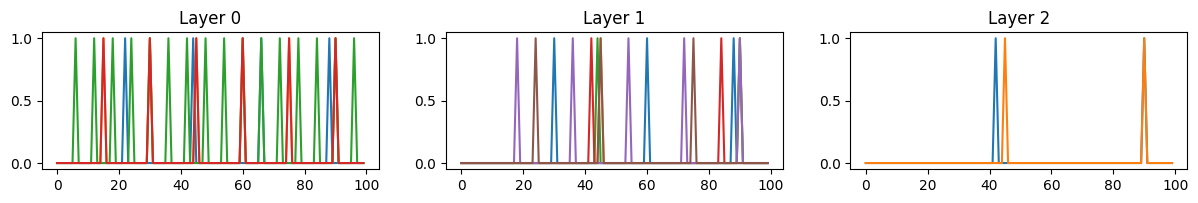

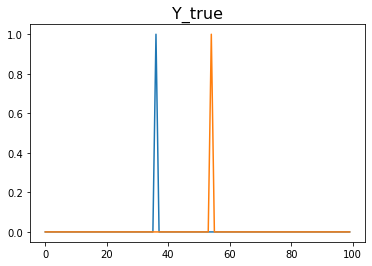

Generation :  46 / 50


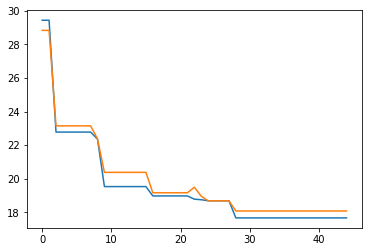

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 55.593220130232936
Mean Test Error by entire population: 55.32055808038432

Random evaluation by best parameter found so far:
Evaluation Error: 9.0


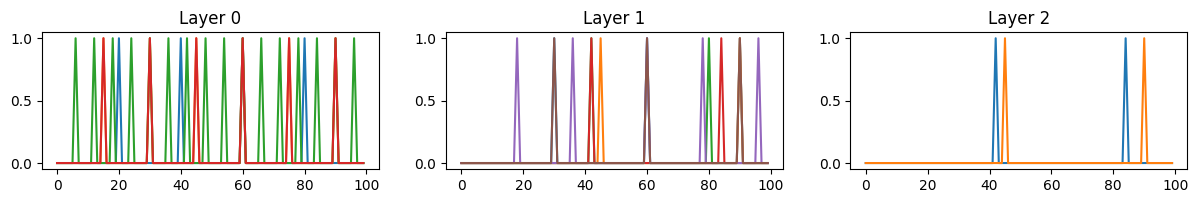

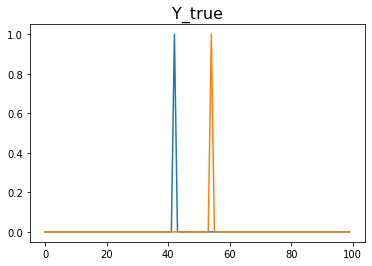

Generation :  47 / 50


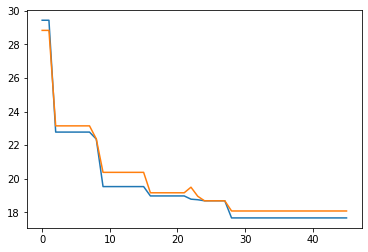

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 37.7617730549923
Mean Test Error by entire population: 37.62882937577159

Random evaluation by best parameter found so far:
Evaluation Error: 4.47213595499958


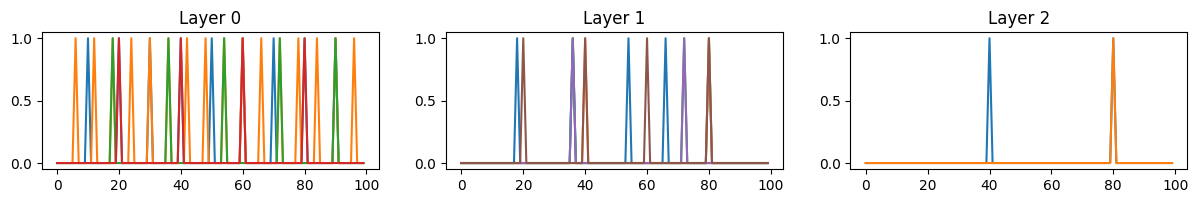

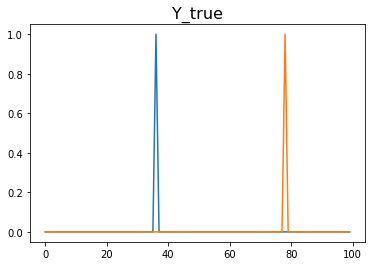

Generation :  48 / 50


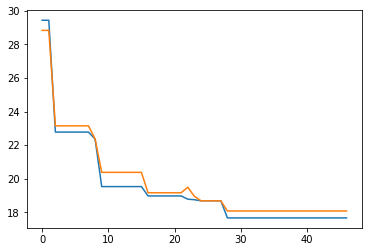

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 44.228489728290384
Mean Test Error by entire population: 44.21461678402164

Random evaluation by best parameter found so far:
Evaluation Error: 4.0


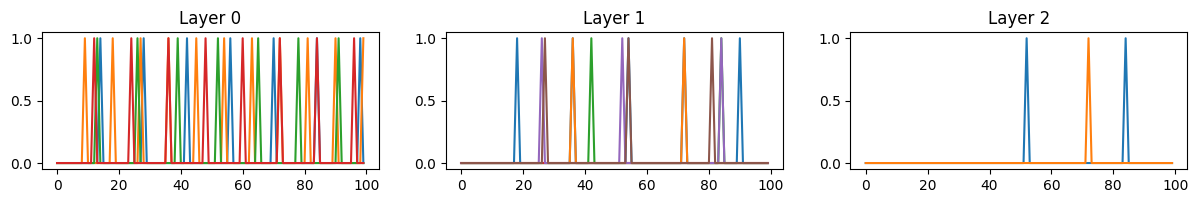

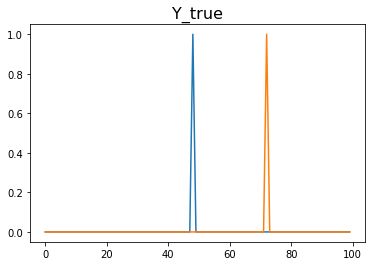

Generation :  49 / 50


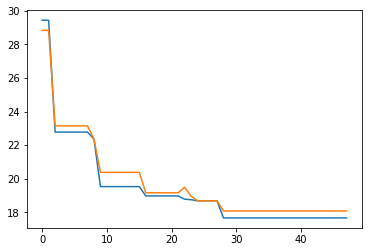

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 49.053856150699445
Mean Test Error by entire population: 49.07794182093075

Random evaluation by best parameter found so far:
Evaluation Error: 18.867962264113206


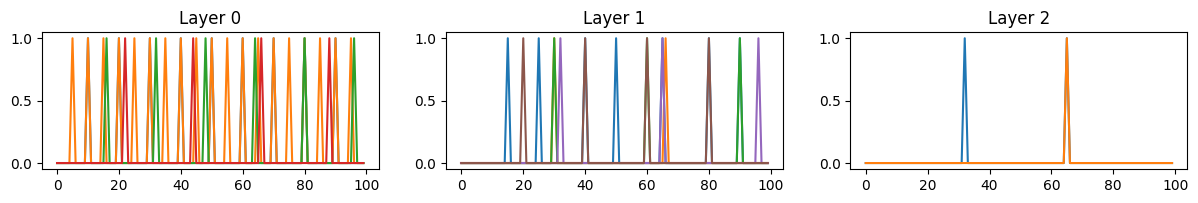

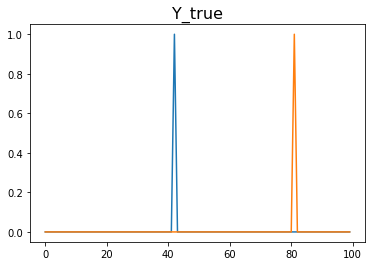

Generation :  50 / 50


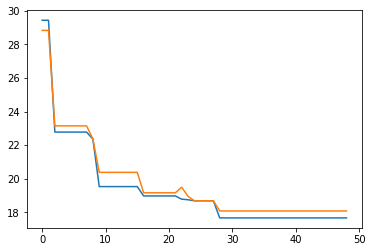

Mean Train Error by best parameters found: 17.668963270615166
Mean Test Error by best parameters found: 18.081914285603332

Mean Train Error by entire population: 49.56689483560178
Mean Test Error by entire population: 49.587252646768654

Random evaluation by best parameter found so far:
Evaluation Error: 22.02271554554524


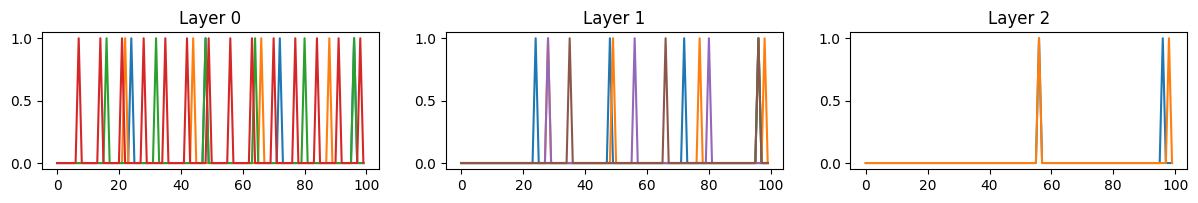

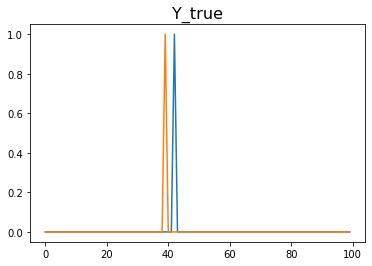

In [0]:
import multiprocessing as mp
output = mp.Queue()

#Genetic algorithm parameters
sol_per_pop = 25
num_parents_mating = 8
num_generations = 50
mutation_percent = 20
ga = GA()

#Neuron parameters
input_dim=4
neurons_per_layer=[6,2]
threshold=0.1
Cm=5

#initial population :       
population_vectors = np.random.uniform(0, 1.5,size=(sol_per_pop, 36)) #4*6 + 6*2 = 36 

best_train_error, best_test_error = [], []
pop_train_error, pop_test_error = [], []

for generation in range(num_generations):

    #Calculate fitness for each population_vector in population    
    #send population vector for each process with id at -1 position

    temp_population_vectors = np.hstack((population_vectors, np.arange(sol_per_pop).reshape(sol_per_pop,1)))
    
    processes=[]
    for syn in temp_population_vectors:
        p = mp.Process(target = mp_fitness, args=(syn, output))
        processes.append(p)
    for p in processes:
        p.start()
    for p in processes:
        p.join()
    results = [output.get() for p in processes]
    results = np.asarray(results)
    results = results[np.argsort(results[:,0])]     #Arrange according to id 
    results = results[:, 1:]                        #remove ids from first column

    fitness_train, fitness_test = [], []
    for r in results:
        fitness_train.append(r[0])
        fitness_test.append(r[1])

    #Select best parents 
    parents = ga.select_mating_pool(population=population_vectors, fitness=fitness_train.copy(), mode='min', num_parents=num_parents_mating)
    #print(parents.shape[0],'New parents generated...')

    #Crossover parents
    offsprings = ga.crossover(parents=parents, num_offsprings=sol_per_pop-num_parents_mating)
    #print(offsprings.shape[0],'New offsprings produced...')
    
    #Mutate offsprings
    mutated_offsprings = ga.mutate(offsprings, mutation_percent=mutation_percent)
    #print(mutated_offsprings.shape[0],'offsprings mutated')
    
    #Create new population
    population_vectors[:parents.shape[0],:] = parents
    population_vectors[parents.shape[0]:,:] = mutated_offsprings
    #print('New population created')
    
    print('============================================================================')
    print("Generation : ", generation+1,'/',num_generations)
    print('============================================================================')    
    if generation != 0:                                             #Ignore first generation since parents are not sorted
        best_train_error.append(fitness_train[0])                   #Mean error by best parameters
        best_test_error.append(fitness_test[0])                     #mean error by best parameters
        plt.plot(best_train_error)
        plt.plot(best_test_error)
        plt.show()           
        print('Mean Train Error by best parameters found:', best_train_error[-1])
        print('Mean Test Error by best parameters found:', best_test_error[-1])
        print()     
        #Update the result of this generation in report files
        '''
        f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/train_error.pkl','wb')
        pickle.dump(best_train_error, f)
        f.close()
        f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/test_error.pkl','wb')
        pickle.dump(best_test_error, f)
        f.close() 
        '''       
    f = open('/content/drive/My Drive/Final_year_project/NLOS_data/SNN_GA/(3)best_paramater_found.pkl','wb')
    pickle.dump(parents[0], f) 
    f.close()
    
    pop_train_error.append(np.mean(fitness_train))              #Mean error by whole population
    pop_test_error.append(np.mean(fitness_test))                #mean error by whole population
    print('Mean Train Error by entire population:', pop_train_error[-1])
    print('Mean Test Error by entire population:', pop_test_error[-1])
    print()
    print('Random evaluation by best parameter found so far:')
    random_evaluate(vector=parents[0], input_dim=input_dim, neurons_per_layer=neurons_per_layer, threshold=threshold, Cm=Cm)